In [93]:
import os
import time
import numpy as np
import pandas as pd
import pywt
import pathlib
import pickle
from itertools import product
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import butter, welch, filtfilt, resample
import math
import nolds
import matplotlib.pyplot as plt

In [6]:
# set path to folder containing clinic watch data
clinicpath = r'//FS2.smpp.local\\RTO\\CIS-PD Study\MJFF Curation\Finalized Dataset'
# set path to folder containing home watch data
homepath = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Patient Record Correlation'
# set path to destination folder
dest = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Watch Features Data'
#---------------------------------------------------------------------------------------------------------

In [ ]:
def power_spectra_welch(rawdata, fm, fM):
    
    # compute the power spectral density of the signal magnitude
    x = rawdata.iloc[:, -1]
    
    # number of samples in the clip
    n = len(x)
    
    # sampling rate of the clip
    Fs = np.mean(1 / (np.diff(x.index) / 1000))
    
    # f: array of sample frequencies present in the signal
    # Pxx: PSD of each sample frequency
    f, Pxx_den = welch(x, Fs, nperseg = min(256, n))
    
    # isolate power spectral density of the desitred frequency range
    inds = (f <= fM) & (f >= fm)
    f = f[inds]
    Pxx_den = Pxx_den[inds]
    
    Pxxdf = pd.DataFrame(data = Pxx_den, index = f, columns = ['PSD_magnitude'])
    
    return Pxxdf

In [ ]:
def feature_extraction(data_clip):
    
    features_list = ['RMSX', 'RMSY', 'RMSZ', 
                     'rangeX', 'rangeY', 'rangeZ', 
                     'meanX', 'meanY', 'meanZ', 
                     'varX', 'varY', 'varZ', 
                     'skewX', 'skewY', 'skewZ', 
                     'kurtX', 'kurtY', 'kurtZ', 
                     'xcorr_peakXY', 'xcorr_peakXZ', 'xcorr_peakYZ', 
                     'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 
                     'freq1', 'freq2', 'freq3', # added
                     'P1_rel', 'P2_rel', 'P3_rel', # added
                     'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 
                     'jerk_mean', 'jerk_std', 'jerk_skew', 'jerk_kur', 
                     'Sen_X', 'Sen_Y', 'Sen_Z', # not included in reduced features
                     'RMS_mag', 'range_mag', 'mean_mag', 'var_mag', 'skew_mag', 'kurt_mag', 'Sen_mag'] # not included
    
    rawdata = data_clip
    rawdata_wmag = rawdata.copy()
    rawdata_wmag['Accel_Mag'] = np.sort((rawdata**2).sum(axis = 1))
    
    N = len(rawdata)
    min_xyz = np.min(rawdata, axis = 0)
    max_xyz = np.max(rawdata, axis = 0)
    xcorr_xy = np.correlate(rawdata.iloc[:, 0], rawdata.iloc[:, 1], mode = 'same')
    xcorr_xz = np.correlate(rawdata.iloc[:,0], rawdata.iloc[:, 2], mode = 'same')
    xcorr_yz = np.correlate(rawdata.iloc[:, 1], rawdata.iloc[:, 2], mode = 'same')
    Pxx = power_spectra_welch(rawdata_wmag, fm = 0, fM = 10)
    sH_raw = []; sH_fft = []

    
    # RMSX, RMSY, RMSZ
    # root mean square
    RMS = 1 / N * np.sqrt(np.asarray(np.sum(rawdata**2, axis = 0)))
    
    # rangeX, rangeY, rangeZ
    # range
    r = np.asarray(max_xyz - min_xyz)
    
    # meanX, meanY, meanZ
    # average
    mean = np.asarray(np.mean(rawdata, axis = 0))

    # varX, varY, varZ
    # standard deviation
    var = np.asarray(np.std(rawdata, axis = 0))

    # skewX, skewY, skewZ
    # skewness: measure of data symmetry
    sk = skew(rawdata)
    
    # kurtX, kurtY, kurtZ
    # kurtosis: measure of data tail weight compared to normal dist
    kurt = kurtosis(rawdata)

    # xcorr_peakXY, xcorr_peakXZ, xcorr_peakYZ
    # max correlation between data of paired axes
    xcorr_peak_xy = np.max(xcorr_xy)
    xcorr_peak_xz = np.max(xcorr_xz)
    xcorr_peak_yz = np.max(xcorr_yz)
    xcorr_peak = np.array([xcorr_peak_xy, xcorr_peak_xz, xcorr_peak_yz])

    # xcorr_lagXY, xcorr_lagXZ, xcorr_lagYZ
    # relative location of max correlation between data of paired axes
    xcorr_lag_xy = (np.argmax(xcorr_xy)) / len(xcorr_xy)
    xcorr_lag_xz = (np.argmax(xcorr_xz)) / len(xcorr_xz)
    xcorr_lag_yz = (np.argmax(xcorr_yz)) / len(xcorr_yz)
    xcorr_lag = np.array([xcorr_lag_xy, xcorr_lag_xz, xcorr_lag_yz])

    # freq1, freq2, freq3
    # frequency with the highest power density
    freq1 = Pxx.iloc[:, -1].index[-1]
    freq2 = Pxx.iloc[:, -1].index[-2]
    freq3 = Pxx.iloc[:, -1].index[-3]
    domfreq = np.array([freq1, freq2, freq3])

    # P1_rel, P2_rel, P3_rel
    # relative power of the dominant frequency within the signal
    P1_rel = Pxx.loc[freq1].values / Pxx.iloc[:, -1].sum()
    P2_rel = Pxx.loc[freq2].values / Pxx.iloc[:, -1].sum()
    P3_rel = Pxx.loc[freq3].values / Pxx.iloc[:, -1].sum()
    Pdom_rel = np.concatenate((P1_rel, P2_rel, P3_rel))

    # PDS_mean, PDS_std, PDS_skew, PDS_kur
    # power spectral density summary stats
    Pxx_moments = np.array([np.nanmean(Pxx.values), np.nanstd(Pxx.values), skew(Pxx.values), kurtosis(Pxx.values)])

    # jerk_mean, jerk_std, jerk_skew, jerk_kur
    jerk = rawdata_wmag['Accel_Mag'].diff().values
    jerk_moments = np.array([np.nanmean(jerk), np.nanstd(jerk), skew(jerk[~np.isnan(jerk)]), kurtosis(jerk[~np.isnan(jerk)])])

    # Sen_X, Sen_Y, Sen_Z
    # sample entropy
    for a in range(3):
        x = rawdata.iloc[:, a]
        n = len(x)
        Fs = np.mean(1 / (np.diff(x.index) / 1000))
        sH_raw.append(nolds.sampen(x))
    
    # features of the acceleration magnitude (as opposed to the axis values)
    RMS_mag = 1 / N * np.sqrt(np.sum(rawdata_wmag['Accel_Mag']**2, axis = 0))
    r_mag = np.max(rawdata_wmag['Accel_Mag']) - np.min(rawdata_wmag['Accel_Mag'])
    mean_mag = np.mean(rawdata_wmag['Accel_Mag'])
    var_mag = np.std(rawdata_wmag['Accel_Mag'])
    sk_mag = skew(rawdata_wmag['Accel_Mag'])
    kurt_mag = kurtosis(rawdata_wmag['Accel_Mag'])
    sH_mag = nolds.sampen(rawdata_wmag['Accel_Mag'])
    
    Y = np.array([RMS_mag, r_mag, mean_mag, var_mag, sk_mag, kurt_mag, sH_mag])
    X = np.concatenate((RMS, r, mean, var, sk, kurt, xcorr_peak, xcorr_lag, 
                        domfreq, Pdom_rel, Pxx_moments, jerk_moments, sH_raw, Y))
    
    return X

[0.5589646]


array([7.8125 , 3.90625, 0.     ])

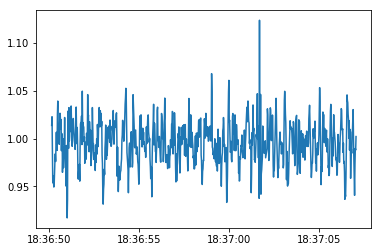

In [128]:
# visualize acceleratin

file = '1032_2_RamR'

data_clip = (pd.read_csv(os.path.join(clinicpath, 'Table8', 'TaskAcc', file + '.csv'), parse_dates = ['timestamp'])
             [['timestamp', 'x', 'y', 'z']])
data_clip.columns = ['Timestamp', 'X', 'Y', 'Z']

rawdata = data_clip[['X', 'Y', 'Z']]
rawdata_wmag = rawdata.copy()
rawdata_wmag['Accel_Mag'] = np.sort((rawdata**2).sum(axis = 1))
rawdata_wmag['Accel_Mag'] = (rawdata**2).sum(axis = 1)

plt.plot(data_clip.Timestamp, rawdata_wmag.Accel_Mag)

x = rawdata_wmag.iloc[:, -1]
n = len(x)
Fs = np.mean(1 / (np.diff(x.index) / 1000))
f, Pxx_den = welch(x, Fs, nperseg = min(256, n))
inds = (f <= 10) & (f >= 0)
f = f[inds]
Pxx_den = Pxx_den[inds]

Pxxdf = pd.DataFrame(data = Pxx_den, index = f, columns = ['PSD_magnitude'])
print(Pxxdf.loc[7.81250].values / Pxxdf.iloc[:, -1].sum())
Pxxdf

freq1 = Pxxdf.iloc[:, -1].index[-1]
freq2 = Pxxdf.iloc[:, -1].index[-2]
freq3 = Pxxdf.iloc[:, -1].index[-3]
domfreq = np.array([freq1, freq2, freq3])
domfreq

,PSD_magnitude
0.00000,0.000011
3.90625,0.000045
7.81250,0.000060


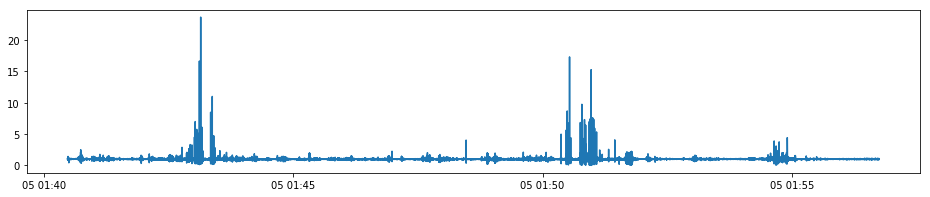

In [105]:
data_clip = (pd.read_csv(os.path.join(homepath, 'Symptom Reports', '1048', '2017-11', '05', '015645.csv'), 
                         parse_dates = ['Timestamp'])
             [['Timestamp', 'X', 'Y', 'Z']])
data_clip.columns = ['Timestamp', 'X', 'Y', 'Z']

rawdata = data_clip[['X', 'Y', 'Z']]
rawdata_wmag = rawdata.copy()
rawdata_wmag['Accel_Mag'] = np.sort((rawdata**2).sum(axis = 1))
rawdata_wmag['Accel_Mag'] = (rawdata**2).sum(axis = 1)

plt.figure(figsize = (16, 3))
plt.plot(data_clip.Timestamp, rawdata_wmag.Accel_Mag)

x = rawdata_wmag.iloc[:, -1]
n = len(x)
Fs = np.mean(1 / (np.diff(x.index) / 1000))
f, Pxx_den = welch(x, Fs, nperseg = min(256, n))
inds = (f <= 10) & (f >= 0)
f = f[inds]
Pxx_den = Pxx_den[inds]

Pxxdf = pd.DataFrame(data = Pxx_den, index = f, columns = ['PSD_magnitude'])
Pxxdf